In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

In [11]:
# Read Data
train = pd.read_csv("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/Preprocessed_data/datafile_nan.csv")

# Index column drop
# Index 열은 Quality에 영향을 주지 않음
train = train.drop(['xq'], axis=1)

# 데이터 타입에 따라 분류
numerical_columns = train.select_dtypes(exclude='object').columns.tolist()

# StandardScaler 를 이용해서 데이터 표준화를 진행한다
# from sklearn.preprocessing import StandardScaler
# train[numerical_columns] = StandardScaler().fit_transform(train[numerical_columns])


# 확인을 위한 호출
print(numerical_columns)
# train.head(5)
# test.head(5)

['Kp_inter', 'Ap_inter', 'F107_inter', 'SunSpot_inter', 'dst', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'C_D', 'S_D', 'C_H', 'S_H', 'tec_ex(T1)']


In [5]:
Y = train['tec_ex(T1)'].values
X = []

for i, rows in train.iterrows():
    # 데이터 프레임을 가로 한줄씩 출력 row
    X.append([ rows['Kp_inter'], rows['Ap_inter'], rows['F107_inter'], rows['SunSpot_inter'], rows['dst']
                , rows['T1'], rows['T2'], rows['T3'], rows['T4'], rows['T5'], rows['T6'], rows['T7'], rows['T8'], rows['T9']
                , rows['T10'], rows['T11'], rows['T12'], rows['T13'], rows['T14'], rows['T15'], rows['T16']
                , rows['C_D'], rows['S_D'], rows['C_H'], rows['S_H']])

# print(X)

NameError: name 'train' is not defined

In [4]:
Y = Y.reshape((-1,1)) # reshape(-1,1) 열 값은 지정했으니 알아서 행 지정해서 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

In [5]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [6]:
#하이퍼 파라미터 튜닝

CFG = {
    'EPOCHS':150, #에포크
    'LEARNING_RATE':3e-4, #학습률
    'BATCH_SIZE':16, #배치사이즈
    'SEED':41, #시드
}

In [7]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=CFG['BATCH_SIZE'], shuffle=True)

valsets = TensorData(X_val, Y_val)
valloader = torch.utils.data.DataLoader(valsets, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [46]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(25, 64, bias=False),
            nn.BatchNorm1d(64, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(64, 128, bias=False),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(128, 256, bias=False),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )
        
        self.layer4 = nn.Linear(256, 1, bias=False)
        
    def forward(self, x): # 모델 연산의 순서를 정의
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
      
        return x

In [47]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'], weight_decay=1e-7)

In [48]:
loss_ = [] # loss 저장할 리스트
t_loss_ = [] # test loss 저장할 리스트

def train(model, optimizer, trainloader):
    n = len(trainloader)
    
    # Loss Function
    criterion = nn.MSELoss()
    best_acc = 0
    
    for epoch in range(1, CFG["EPOCHS"]+1):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, values = data
            
            optimizer.zero_grad() # 최적화 초기화
            
            outputs = model(inputs) # 예측값 산출
            loss = criterion(outputs, values) # Error 계산
            
            loss.backward() # 역전파 진행
            optimizer.step() # 역전파 진행 후 가중치 업데이트
            
            running_loss += loss.item() # Epoch 마다 평균 loss를 계산하기 위한 배치 loss
                                        # item() 텐서로 값 받아오기
        
        loss_.append(running_loss/n) # MSE 계산
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(trainloader)))
        
        #validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        test_loss = 0.0
        
        predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
        actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.
        
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for i, data in enumerate(valloader, 0):
                inputs, values = data

                outputs = model(inputs)
                test_loss += criterion(outputs, values)
                
                predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
                actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.
                
                t_loss_.append(test_loss/n)
        
        predictions = predictions.numpy() # 넘파이 배열로 변경.
        actual = actual.numpy() # 넘파이 배열로 변경.
        rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.
        print(f'test rmse:{rmse}')
        
        

In [49]:
train(model, optimizer, trainloader)

[1] Train loss: 0.0251415800
test rmse:0.10494793206453323
[2] Train loss: 0.0128337684
test rmse:0.08332432806491852
[3] Train loss: 0.0096116760
test rmse:0.08030737191438675
[4] Train loss: 0.0083457092
test rmse:0.06626685708761215
[5] Train loss: 0.0079521053
test rmse:0.066041499376297
[6] Train loss: 0.0066763275
test rmse:0.05984695628285408
[7] Train loss: 0.0062243422
test rmse:0.058048978447914124
[8] Train loss: 0.0059946457
test rmse:0.05737899988889694
[9] Train loss: 0.0060218421
test rmse:0.06196878105401993
[10] Train loss: 0.0056223716
test rmse:0.051994673907756805
[11] Train loss: 0.0055441129
test rmse:0.05325981602072716
[12] Train loss: 0.0051042365
test rmse:0.0606328584253788
[13] Train loss: 0.0051810155
test rmse:0.062218356877565384
[14] Train loss: 0.0050703673
test rmse:0.05577697977423668
[15] Train loss: 0.0046195594
test rmse:0.053287751972675323
[16] Train loss: 0.0045658608
test rmse:0.05481483414769173
[17] Train loss: 0.0043044402
test rmse:0.050720

[137] Train loss: 0.0016921572
test rmse:0.023647816851735115
[138] Train loss: 0.0012300747
test rmse:0.027863213792443275
[139] Train loss: 0.0013337734
test rmse:0.024115461856126785
[140] Train loss: 0.0014254584
test rmse:0.027529748156666756
[141] Train loss: 0.0012427645
test rmse:0.0316234715282917
[142] Train loss: 0.0010756306
test rmse:0.04351009428501129
[143] Train loss: 0.0012614746
test rmse:0.03265957161784172
[144] Train loss: 0.0014148929
test rmse:0.024363605305552483
[145] Train loss: 0.0012866402
test rmse:0.024721411988139153
[146] Train loss: 0.0015373118
test rmse:0.028522111475467682
[147] Train loss: 0.0011067335
test rmse:0.031043745577335358
[148] Train loss: 0.0014308463
test rmse:0.03399321809411049
[149] Train loss: 0.0015031109
test rmse:0.025907224044203758
[150] Train loss: 0.0010314290
test rmse:0.029584970325231552


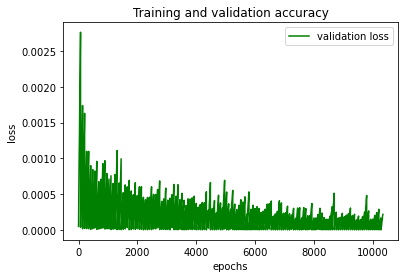

In [53]:
plt.clf()
# plt.plot(loss_,'ro',label='training loss')
plt.plot(t_loss_,'g',label='validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
sample_submission['tec_ex(T1)'] = y_pred_label.astype(int)
sample_submission.to_csv("C:/Users/rihot/Desktop/Deep_learning/capston_assignment/processed data/sample_submission.csv", index=False)